In [1]:
import os
import glob
import pickle
import string
from tqdm.notebook import tqdm

import numpy as np
import seaborn as sns
import pandas as pd
from scipy.fft import fft

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import ImageGrid, make_axes_locatable, Size, Divider
import matplotlib.colors as mcolors


In [2]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, FunctionTransformer, normalize

In [3]:
master = pd.read_excel('/mnt/c/Users/conor/OneDrive/Desktop/master_xl_1507.xlsx')
gb = list(master.groupby('REF'))

# Plots for Caroline

In [4]:
for name, row in gb:

    break

    fig, axes = plt.subplots(ncols=3, figsize=(15,5))

    he = matplotlib.image.imread(row.iloc[0,1])
    ann = matplotlib.image.imread(row.iloc[0,4])
    ftir = pd.read_hdf(row.iloc[0,5], key='Data').values.reshape(256,256,-1)[:,:,195]

    fig.suptitle(name)

    for ax, im, tit in zip(axes.flatten(), [he, ann, ftir], ['H&E', 'Annotation', 'Amide 1']):

        ax.imshow(im, aspect='auto')
        ax.set_title(tit)

    fig.savefig(f'/mnt/c/Users/conor/Git_Projects/PHD/Work_For_Caroline/Plots_September/{name}.pdf', bbox_inches='tight')
    plt.close(fig)

# Annotation Plot

<ipython-input-5-d7fcd772afe8>:2: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.subplots_adjust(wspace=0)


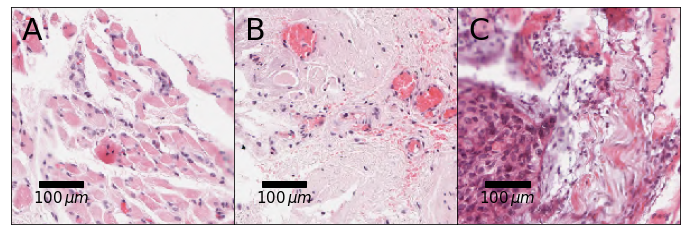

In [5]:
fig, axes = plt.subplots(ncols=3, figsize=(12,4), constrained_layout = True)
fig.subplots_adjust(wspace=0)
[(ax.set_xticks([]), ax.set_yticks([])) for ax in axes];

sbx, sby = 0.1, 0.1
sb = 100

for let, ax, (indx, row) in zip(string.ascii_uppercase, axes.flatten(), master.sample(3).iterrows()):

    he = matplotlib.image.imread(row['HE'])

    ax.imshow(he[200:400, 200:400], aspect='auto')
    ax.text(0.05, 0.85, let, size=30.0, transform=ax.transAxes)
    ax.add_patch(Rectangle((sbx+0.025, sby+0.07), 0.2, 0.03, color='black', transform=ax.transAxes))
    ax.text(sbx, sby, f'${sb}\/\mu m$', size=15.0, transform=ax.transAxes)

fig.savefig('./Annotation.pdf', bbox_inches='tight')

# Complex Permittivity

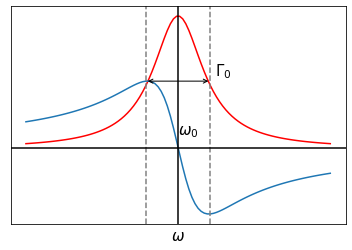

In [6]:
def real_permit(x, wi, gamma):

    y = ((wi**2 - x**2)/((wi**2 - x**2)**2 + (gamma**2*x**2)))

    return y

def complex_permit(x, wi, gamma):

    y = (x*gamma)/((wi**2 - x**2)**2 + (gamma**2*x**2))

    return y

x = np.linspace(-0.5,0.5,100)

yr = real_permit(x, wi=1, gamma=-10) #+ real_permit(x, wi=0.5, gamma=0.005)
yc = complex_permit(x, wi=1, gamma=-10)# + complex_permit(x, wi=0.5, gamma=1)

fig, ax = plt.subplots(1)

ax.plot(x, yr, c='r')
ax.plot(x, yc)

ax.set_xlabel('$\omega$', size=15.0)
ax.axvline(0, c='black', ls='-')

ax.axvline(x[np.argmin(yc)], c='gray', ls='--')
ax.axvline(x[np.argmax(yc)], c='gray', ls='--')

ax.axhline(0, c='black')
ax.annotate("", xy=(x[np.argmin(yc)], np.max(yc)), xytext=(x[np.argmax(yc)], np.max(yc)), arrowprops=dict(arrowstyle="<->"))


ax.text(0, 0.1,'$\omega_0$', c='black', size=15.0)
ax.text(0.12, 0.55,'$\Gamma_0$', c='black', size=15.0)

ax.set_xticks([])
ax.set_yticks([])

fig.savefig('./Complex_Permittivity.pdf', bbox_inches='tight')


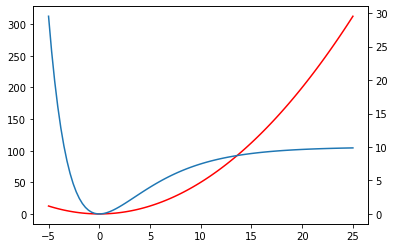

In [7]:
def harmonic_potential(x,k,re):

    y = k*0.5*(x-re)**2# -1 

    return y

def anharmonic_potential(x, a, re, De=10):

    y = De*(1 - np.exp(-a*(x-re)))**2# -1

    return y

x = np.linspace(-5,25,100)

yh = harmonic_potential(x, 1, 0) #+ real_permit(x, wi=0.5, gamma=0.005)
ya = anharmonic_potential(x, 0.2, 0)# + complex_permit(x, wi=0.5, gamma=1)

fig, ax = plt.subplots()

ax.plot(x, yh, c='r')
#ax.plot(x, yc, c='g')

ax2 = ax.twinx()
ax2.plot(x, ya)

#ax.set_xticks([])
#ax.set_yticks([])

#fig.savefig('./Complex_Permittivity.pdf', bbox_inches='tight')


# Spectrum Example Plot

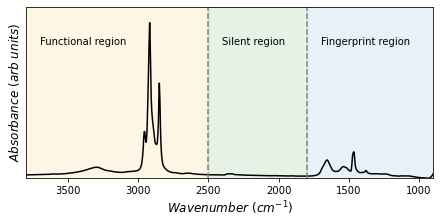

In [8]:
name, row = gb[50]

fig, ax = plt.subplots(figsize=(6,3), constrained_layout = True)

ftir = pd.read_hdf(row.iloc[0,5], key='Data')

mean = ftir.mean(axis=0)

ax.plot(ftir.columns, mean, color='black')
ax.invert_xaxis()
ax.set_xlabel('$Wavenumber\ (cm^{-1})$', fontsize = 12)
ax.set_ylabel('$Absorbance\ (arb\ units)$', fontsize = 12)

ax.axvline(1800, ls='--', ymax=np.max(mean)*1.1, color='gray')

ax.text(1700, 1.5,'Fingerprint region', c='black', size=10.0)
ax.fill_between((1800,np.min(ftir.columns)), y1=np.max(mean)*1.1, alpha=0.1)
ax.axvline(2500, ls='--', ymax=np.max(mean)*1.1, color='gray')

ax.text(2400, 1.5,'Silent region', c='black', size=10.0)
ax.fill_between((2500,1799), y1=np.max(mean)*1.1, alpha=0.1, color='green')

ax.text(3700, 1.5,'Functional region', c='black', size=10.0)
ax.fill_between((np.max(ftir.columns),2499), y1=np.max(mean)*1.1, alpha=0.1, color='orange')

ax.set_xlim(np.max(ftir.columns), np.min(ftir.columns))
ax.set_ylim(np.min(mean), np.max(mean)*1.1)
ax.set_yticks([])

fig.savefig(f'./spectrum_example.pdf', bbox_inches='tight')
#plt.close(fig)

/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/matplotlib/transforms.py:2802: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


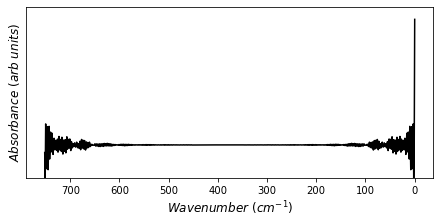

In [9]:
name, row = gb[15]

fig, ax = plt.subplots(figsize=(6,3), constrained_layout = True)

ftir = pd.read_hdf(row.iloc[0,5], key='Data')

mean = ftir.mean(axis=0)
interferogram = fft(mean.values)

ax.plot(interferogram.real, color='black')
ax.invert_xaxis()
ax.set_xlabel('$Wavenumber\ (cm^{-1})$', fontsize = 12)
ax.set_ylabel('$Absorbance\ (arb\ units)$', fontsize = 12)

#ax.set_xlim(np.max(ftir.columns), np.min(ftir.columns))
ax.set_ylim(np.min(interferogram), np.max(interferogram)*1.1)
ax.set_yticks([])

fig.savefig(f'./Interferogram_example.pdf', bbox_inches='tight')
#plt.close(fig)

<ipython-input-10-ff166e6cfc1d>:28: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  ax = fig.gca(projection='3d')


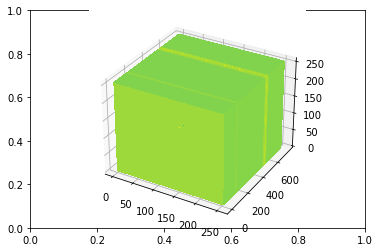

In [10]:
def plot_cube_faces(arr, ax):
    """
    External faces representation of a 3D array with matplotlib

    Parameters
    ----------
    arr: numpy.ndarray()
        3D array to handle
    ax: Axes3D object
        Axis to work with
    """
    x0 = np.arange(arr.shape[0])
    y0 = np.arange(arr.shape[1])
    z0 = np.arange(arr.shape[2])
    x, y, z = np.meshgrid(x0, y0, z0)
    
    xmax, ymax, zmax = max(x0), max(y0), max(z0)
    vmin, vmax = np.min(arr), np.max(arr)

    ax.contourf(x[:, :, 0], y[:, :, 0], arr[:, :, -1].T,
                zdir='z', offset=zmax, vmin=vmin, vmax=vmax)
    ax.contourf(x[0, :, :].T, arr[:, 0, :].T, z[0, :, :].T,
                zdir='y', offset=0, vmin=vmin, vmax=vmax)
    ax.contourf(arr[-1, :, :].T, y[:, 0, :].T, z[:, 0, :].T,
                zdir='x', offset=xmax, vmin=vmin, vmax=vmax)

fig, ax = plt.subplots(1)
ax = fig.gca(projection='3d')

#plot_cube_faces(np.log(np.moveaxis(ftir.values.reshape(256,256,-1),-1,1)-ftir.values.min()+1e-10), ax)
plot_cube_faces(np.log(np.moveaxis(ftir.values.reshape(256,256,-1),-1,1)+10), ax)

#plt.show()